# Generate plots
This notebook aims to generate several plot used during the specialization project. 

In [13]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from plotly.subplots import make_subplots
from sklearn.metrics import r2_score

cols = plotly.colors.DEFAULT_PLOTLY_COLORS

## Emission goals for each country

These links shows where the data are gathered from

**Denmark** \
[2030 Target](https://um.dk/en/foreign-policy/new-climate-action-strategy) \
[2022 Progress](https://www.dst.dk/en/Statistik/emner/miljoe-og-energi/groent-nationalregnskab/energi-og-emissionsregnskaber)

**Germany** \
[2030 Target](https://www.bundesregierung.de/breg-de/schwerpunkte/klimaschutz/klimaschutzgesetz-2021-1913672) \
[2022 Progress](https://www.umweltbundesamt.de/en/press/pressinformation/uba-forecast-2022-greenhouse-gas-emissions-down-19)

**United Kingdom** \
[2030 Target](https://researchbriefings.files.parliament.uk/documents/CBP-9888/CBP-9888.pdf) \
[2022 Progress](https://www.ons.gov.uk/economy/environmentalaccounts/bulletins/greenhousegasintensityprovisionalestimatesuk/provisionalestimates2022)

**Sweden** \
[2030 Target](https://climate-laws.org/document/the-swedish-climate-policy-framework_747b) \
[2022 Progress](https://www.statistikdatabasen.scb.se/pxweb/en/ssd/START__MI__MI0107/TotaltUtslappN/table/tableViewLayout1/) \
NATIONAL TOTAL (excluding LULUCF, excluding international transports)

**Finland** \
[2030 Target](https://valtioneuvosto.fi/en/-//1410903/annual-climate-report-additional-measures-are-needed-to-achieve-climate-targets#) \
[2022 Progress](https://www.treasuryfinland.fi/investor-relations/sustainability-and-finnish-government-bonds/data-finlands-ghg-emissions-energy-transition)

**France** \
[2030 Target](https://www.strategie.gouv.fr/sites/strategie.gouv.fr/files/atoms/files/fs-the-value-for-climate-action-final-web.pdf) \
[2022 Progress](https://www.statistiques.developpement-durable.gouv.fr/edition-numerique/chiffres-cles-du-climat-2023/en/9-french-overview-of-greenhouse-gases)

**Norway** \
[2030 Target and 2022 Progress](https://www.ssb.no/natur-og-miljo/forurensning-og-klima/statistikk/utslipp-til-luft/artikler/liten-nedgang-i-utslipp-av-klimagasser-i-2022) \

In [14]:
df = pd.DataFrame({
    'Country': ['Denmark', 'Germany', 'United Kingdom', 'Sweden', 'Finland', 'Norway', 'France'],
    'Current Emission Reduction': [41, 40, 49, 37, 36, 5, 26],
    'Emission Reduction Goal': [70, 65, 67, 63, 60, 55, 57]
})

# Define the order of countries
country_order = ['Norway', 'Sweden', 'Denmark', 'Finland', 'United Kingdom', 'Germany', 'France']

# Creating the barplot
fig = go.Figure()

# Adding the "Emission Reduction Goal" bar
fig.add_trace(go.Bar(
    x=df['Country'],
    y=df['Emission Reduction Goal'],
    name='2030 Target',
    marker_color=cols[0],
    text=[f'{val}' for val in df["Emission Reduction Goal"]]
))

# Adding the "Current Emission Reduction" bar
fig.add_trace(go.Bar(
    x=df['Country'],
    y=df['Current Emission Reduction'],
    name='2022 progress',
    marker_color=cols[1],
    text=[f'{val}' for val in df["Current Emission Reduction"]],
))

# Update the order of countries
fig.update_xaxes(categoryorder='array', categoryarray=country_order)

# Updating the layout
fig.update_layout(
    height=600, 
    width=1000, 
    barmode='overlay', # Overlay the bars
    xaxis_title='Country',
    yaxis_title='Emission Reduction (%)',
    margin=dict(l=20, r=20, t=20, b=20),
    legend=dict(orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=0.6),
    template="seaborn",
    font=dict(family="Helvetica", size=18),
)

# Display the plot
fig.show()

## CO2 Moisture Content

In [15]:
def generate_moisture_df(P_tot, T, P_H2O):
    Mm_CO2 = 44.01 # g/mol
    Mm_H2O = 18.02 # g/mol
    results = []
    for P in P_tot:
        # Convert P from barg to bar
        # Convert PH2O from MPa to bar
        x_CO2 = 1 - (P_H2O*10) / (P+1) # Mole fraction
        w_CO2 = x_CO2 * Mm_CO2 / (x_CO2 * Mm_CO2 + (1 - x_CO2) * Mm_H2O ) # Mass fraction
        results.append(w_CO2)

    moisture_df = pd.DataFrame(results, index=P_tot, columns=T)
    moisture_df = moisture_df.rename(columns=lambda x: str(x) + "°C").round(2)
    return moisture_df

def plot_TP_distribution(df):
    """
    Plot the distribution of P6 and T10 in a heatmap.

    Args:
        df (pandas.DataFrame): The input DataFrame containing all PFD data.

    Returns:
        None
    """
    
    # Picking colormap
    cmap_name = "viridis"
    cmap = cm.get_cmap(cmap_name)
    colormap_list = [cmap(i) for i in range(cmap.N)]

    # Create bins for P6 and T10
    p6_bins = np.linspace(0.4, 1.2, 6)
    t10_bins = np.linspace(10, 35, 11)

    # Create a binned DataFrame
    df_binned = pd.DataFrame({
        'P6': pd.cut(df['P6'], bins=p6_bins, include_lowest=True, right=False),
        'T10': pd.cut(df['T10'], bins=t10_bins, include_lowest=True, right=False)
    })

    # Calculate the percentage of data points in each bin
    heatmap_data = df_binned.groupby(['P6', 'T10']).size().reset_index(name='count')
    heatmap_data['percentage'] = 100 * heatmap_data['count'] / len(df)
    heatmap_pivot = heatmap_data.pivot("P6", "T10", "percentage")

    # Plotting the heatmap
    plt.figure(figsize=(16, 8), dpi=300)
    sns.set(font="Verdana")
    sns.set(rc={'axes.facecolor':colormap_list[0]})
    sns.heatmap(heatmap_pivot, annot=True, cmap=cmap_name, 
                fmt=".1f", cbar=True, mask=heatmap_pivot <= 0.15)
    plt.xlabel("T10 intervals [°C]", labelpad=15)
    plt.ylabel("P6 intervals [barg]", labelpad=15)
    plt.show()

In [16]:
df = pd.read_pickle("../data/processed/SRD_Lysekil.pkl")

fig = go.Figure(data=go.Scatter(x=df["T10"], y=df["P6"], mode='markers'))
fig.update_layout(title="Desorber pressure plotted against condenser temperature", xaxis_title="T10 [°C]", yaxis_title="P6 [barg]")
fig.show()

From the above plot, we can observe 3 distinct pressures and a temperature range of the condenser. This can be used to calculate the moisture content in the $F10$ stream. In order to calculate the moisture content of the $CO_2$ outlet stream, we can utilize the vapor pressure of water as the following Equation from Daltons Law:

\begin{equation*}
    P_{tot} = P_{CO_2} + P_{H_2O}
\end{equation*}

where 

\begin{equation*}
    P_{H_2O} = f(T)
\end{equation*}

which can be found in thermodynamical data sheets. In order to calculate the molar composition, we can use Raoults law:

\begin{align*}
    P_{tot}  &= x_{CO_2} P_{CO_2} \\
    \\
    x_{CO_2} &= \frac{P_{tot}}{P_{CO_2}}= 1 - \frac{P_{H_2O}}{P_{CO_2}}
\end{align*}

Since the measurement of the $CO_2$ stream is given in mass, we transform this into mass fraction.

\begin{align*}
    w_{CO_2} &= \frac{m_{CO_2}}{m_{CO_2} + m_{H_2O}} \\
             &= \frac{x_{CO_2}n_{tot}Mm_{CO_2}}{x_{CO_2}n_{tot}Mm_{CO_2} + x_{H_2O}n_{tot}Mm_{H_2O}} \\
             &= \frac{x_{CO_2}Mm_{CO_2}}{x_{CO_2}Mm_{CO_2} + (1 - x_{CO_2})Mm_{H_2O}}
\end{align*}

In [17]:
# Picking some intervals by looking at the dropdown plot
P_tot = np.linspace(0.5, 2, 7) # barg
T = np.array([10, 15, 20, 25, 30, 35, 40, 45]) # °C

# Partial pressure of water vapor in MPa 
# from Perry's Chemical Engineers' Handbook
P_H2O = np.array([0.0012282, 0.0017058, 0.0023393, 0.0031699, 
                  0.0042470, 0.0056290, 0.0073849, 0.0095950])

generate_moisture_df(P_tot, T, P_H2O)

10°C  15°C  20°C  25°C  30°C  35°C  40°C  45°C
0.50   1.0   1.0  0.99  0.99  0.99  0.98  0.98  0.97
0.75   1.0   1.0  0.99  0.99  0.99  0.99  0.98  0.98
1.00   1.0   1.0  1.00  0.99  0.99  0.99  0.98  0.98
1.25   1.0   1.0  1.00  0.99  0.99  0.99  0.99  0.98
1.50   1.0   1.0  1.00  0.99  0.99  0.99  0.99  0.98
1.75   1.0   1.0  1.00  1.00  0.99  0.99  0.99  0.99
2.00   1.0   1.0  1.00  1.00  0.99  0.99  0.99  0.99

From the above Table, we can see that the moisture content is generally under 3%, however to determine whether or not this will pose an issue for our approximations, we make a overview of the data.

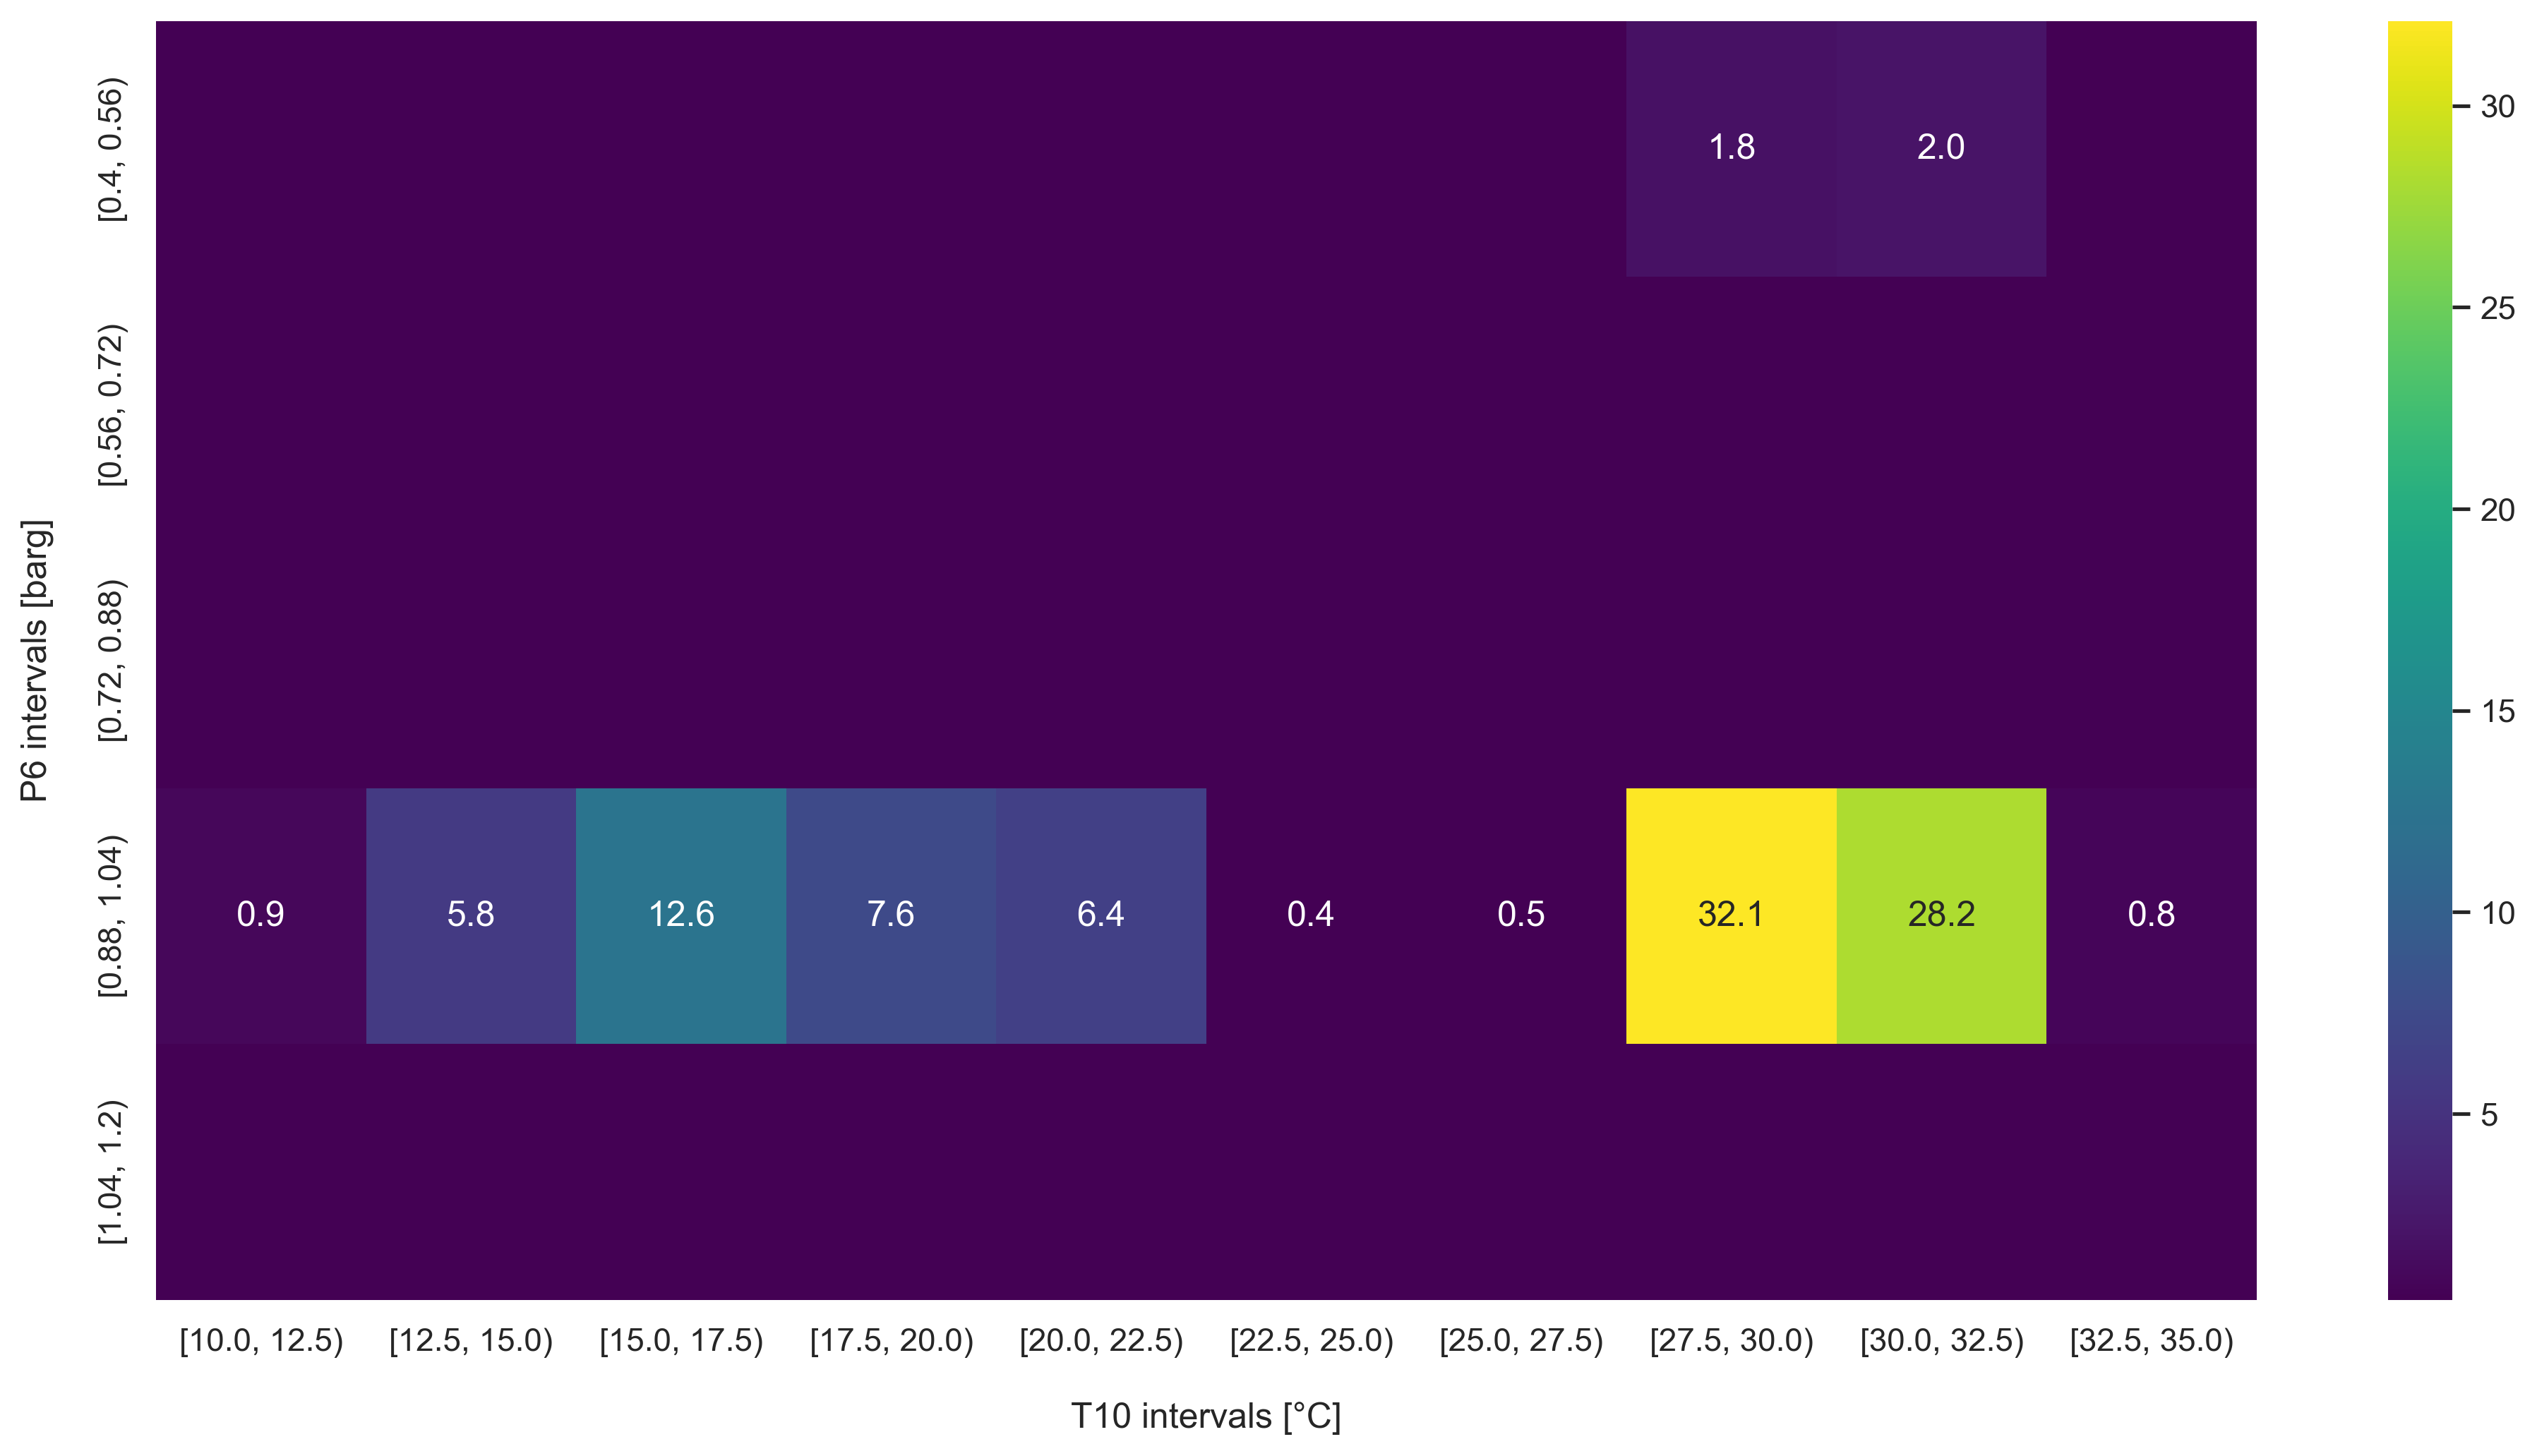

In [18]:
plot_TP_distribution(df)

## Visualize selected temperatures
Used for data exploration and showing how some temperatures vary of the period of operation.

In [19]:
df = pd.read_pickle("../data/processed/renamed_Lysekil.pkl")
fig = px.scatter(df, x="Time", y=["T1", "T2", "T3"], template="simple_white")

fig.update_traces(marker=dict(size=4,), 
                  selector=dict(mode='markers'))

fig.update_layout(height=600, 
                  width=1000, 
                  margin=dict(b=60, t=40, r=30),
                  xaxis_title='Time', 
                  yaxis_title='Temperature [°C]', 
                  legend_title='Sensors', 
                  legend= {'itemsizing': 'constant'}, 
                  font=dict(family="Helvetica", size=18)
                )

fig.show()
fig.write_image("../figs/temperature.pdf")

## Temperature vs Height plots (aka temperature profile along the desorber)
Starting off with the data from MTU and Aspen Plus across the five cases and a plot function

In [20]:
# Constants
tot_sec = 61
column_height = 11
height = (11 * np.arange(1, tot_sec + 1) / 61)[::-1]
indices = [0, 18, 42, 60]

# Some data from Aspen Plus
aspen1 = np.array([98.29, 99.8889, 99.9541, 99.9827, 100.01, 100.038, 100.065, 100.092, 100.12, 100.147, 100.174, 100.201, 100.228, 100.255, 100.281, 100.308, 100.335, 100.385, 102.956, 102.89, 102.862, 102.85, 102.824, 102.793, 102.761, 102.729, 102.697, 102.665, 102.635, 102.605, 102.576, 102.55, 102.526, 102.507, 102.492, 102.486, 102.49, 102.51, 102.551, 102.623, 102.735, 102.903, 103.145, 103.484, 103.944, 104.551, 105.324, 106.272, 107.385, 108.634, 109.975, 111.352, 112.713, 114.017, 115.239, 116.366, 117.399, 118.346, 119.216, 120.023, 122.274])
aspen2 = np.array([104.165,106.081,106.164,106.198,106.23,106.263,106.296,106.328,106.36,106.393,106.425,106.457,106.489,106.521,106.552,106.584,106.617,106.678,109.351,109.272,109.242,109.225,109.191,109.153,109.115,109.077,109.041,109.007,108.977,108.951,108.931,108.92,108.923,108.943,108.988,109.069,109.198,109.392,109.675,110.071,110.61,111.317,112.212,113.297,114.556,115.947,117.413,118.89,120.321,121.664,122.894,124.003,124.993,125.875,126.661,127.367,128.006,128.592,129.137,129.651,131.352])
aspen3 = np.array([94.9265, 96.2343, 96.278, 96.2956, 96.3127, 96.3298, 96.3468, 96.3637, 96.3807, 96.3976, 96.4144, 96.4312, 96.448, 96.4648, 96.4815, 96.4981, 96.5154, 96.5519, 99.0136, 99.4083, 99.3642, 99.815, 100.372, 100.974, 101.599, 102.233, 102.866, 103.489, 104.096, 104.681, 105.24, 105.77, 106.271, 106.742, 107.184, 107.598, 107.987, 108.35, 108.692, 109.013, 109.315, 109.601, 109.873, 110.131, 110.378, 110.615, 110.844, 111.066, 111.282, 111.494, 111.704, 111.911, 112.119, 112.328, 112.54, 112.758, 112.983, 113.217, 113.463, 113.724, 115.046])
aspen4 = np.array([99.9979, 101.55, 101.607, 101.63, 101.651, 101.673, 101.695, 101.716, 101.738, 101.759, 101.781, 101.802, 101.823, 101.845, 101.866, 101.887, 101.909, 101.956, 104.561, 104.5, 104.468, 104.462, 104.443, 104.42, 104.396, 104.372, 104.348, 104.324, 104.3, 104.276, 104.253, 104.23, 104.207, 104.185, 104.164, 104.145, 104.128, 104.115, 104.108, 104.108, 104.119, 104.146, 104.197, 104.281, 104.412, 104.61, 104.897, 105.302, 105.858, 106.592, 107.523, 108.652, 109.951, 111.371, 112.847, 114.317, 115.73, 117.056, 118.281, 119.404, 122.21])
aspen5 = np.array([97.0763, 98.7314, 98.8162, 98.8619, 98.9065, 98.9509, 98.9951, 99.039, 99.0828, 99.1264, 99.1698, 99.2129, 99.2559, 99.2987, 99.3413, 99.3838, 99.4267, 99.4898, 102.035, 102.212, 102.261, 102.603, 103.059, 103.623, 104.295, 105.069, 105.931, 106.861, 107.832, 108.815, 109.786, 110.72, 111.603, 112.423, 113.177, 113.864, 114.487, 115.051, 115.56, 116.021, 116.44, 116.822, 117.171, 117.492, 117.79, 118.067, 118.327, 118.572, 118.805, 119.03, 119.246, 119.457, 119.665, 119.871, 120.079, 120.289, 120.506, 120.732, 120.969, 121.223, 122.479])

# Data from plant
case1 = np.array([95.89459991, 102.7618256, 107.7140808, 119.9893417])
case2 = np.array([98.9262085, 108.6126938, 110.0705872, 127.4315796])
case3 = np.array([95.89459991, 102.7618256, 107.7140808, 119.9893417])
case4 = np.array([95.11543274, 103.865715, 103.7567062, 118.0025864])
case5 = np.array([89.06851196, 98.90103149, 100.8353729, 118.9804306])

def make_sub(height, aspen, case, row, col):
    fig.add_trace(
        go.Scatter(y=height, x=aspen, line_shape='spline', 
                line=dict(width=7, color=cols[0])),
        row=row, col=col)

    fig.add_trace(
        go.Scatter(y=height[indices], x=case, mode='markers', 
                   marker=dict(size=12, 
                               symbol='square', 
                               color=cols[0], 
                               line=dict(color='Black', width=1)
                               )
                   ),
                    row=row, col=col)

Plotting the actual temperature profiles and saves as PDF.

In [21]:
fig = make_subplots(rows=1, cols=5,
                    x_title='Temperature [°C]',
                    y_title='Height [m]',
                    subplot_titles=('BC',  'C1', 'C3', 'E1', 'E3'))

make_sub(height, aspen1, case1, 1, 1)
make_sub(height, aspen2, case2, 1, 2)
make_sub(height, aspen3, case3, 1, 3)
make_sub(height, aspen4, case4, 1, 4)
make_sub(height, aspen5, case5, 1, 5)

for i in range(1, 6):
    for j in range(1, 6):
        x_axis_name = f'xaxis{i}' if i == 1 else f'xaxis{i*j}'
        y_axis_name = f'yaxis{i}' if i == 1 else f'yaxis{i*j}'
        fig.update_layout(
            **{x_axis_name: dict(linewidth=2, linecolor="Black")},
            **{y_axis_name: dict(linewidth=2, linecolor="Black")}
        )

fig.update_annotations(font_size=24)
fig.update_layout(height=600, width=1200, 
                  showlegend=False, template="simple_white",
                  font=dict(family="Helvetica", size=18),
                  margin=dict(b=70, t=40, r=30))

fig.show()
fig.write_image("../figs/TempHeight.pdf", width=1200, height=600, scale=2)

## Parity plot of lean and rich density

In [22]:
# Data from MTU
D1_MTU = np.array([1088.11499, 1090.425293, 1090.595581, 1091.443726, 1108.435303])
D8_MTU = np.array([1017.941345, 1023.984192, 1020.980042, 1034.57373, 1040.16333])
MTU = np.concatenate((D1_MTU, D8_MTU))

# Data from Aspen Plus
lean_loading = np.array([0.213032066, 0.145038172, 0.171347247, 0.24247849, 0.133190926])
D1_sim = np.array([1055.581956, 1048.781284, 1069.583962, 1051.411844, 1058.672435])
D8_sim = np.array([990.1087732, 968.775124, 987.9521059, 996.0362459, 974.1782947])
sim = np.concatenate((D1_sim, D8_sim))


# Rest of the plot
x = 960
y = 1120

fig = go.Figure(layout_yaxis_range=[x,y], layout_xaxis_range=[x,y])

fig.add_trace(go.Scatter(x=D1_MTU, 
                         y=D1_sim, 
                         mode='markers', 
                         name='Rich density',
                         marker=dict(size=12))
              )

fig.add_trace(go.Scatter(x=D8_MTU, 
                         y=D8_sim, 
                         mode='markers', 
                         name='Lean density',
                         marker=dict(size=12))
              )

fig.add_trace(go.Scatter(x=[x, y], 
                         y=[x, y], 
                         name='1:1 line', 
                         mode='lines', 
                         line={'dash': 'dash', 'color': 'grey'})
              )

fig.update_annotations(font_size=24)
fig.update_layout(
    xaxis_title='Observed (MTU)',
    yaxis_title='Predicted (Aspen Plus)',
    template="simple_white",
    font=dict(family="Helvetica", size=18),
    legend=dict(x=0.05,y=0.95),
    height=600, 
    width=1200,
    margin=dict(t=10, r=20)
)

fig.show()
fig.write_image("../figs/Density.pdf")

## Legacy plots (not used)

In [23]:
fig = make_subplots(rows=3, cols=2,
                    specs=[[{}, {}],
                           [{}, {}],
                           [{"colspan": 2}, None]],
                    subplot_titles=('Case 1',  'Case 2', 'Case 3', 'Case 4', 'Case 5'))

make_sub(height, aspen1, case1, 1, 1)
make_sub(height, aspen2, case2, 1, 2)
make_sub(height, aspen3, case3, 2, 1)
make_sub(height, aspen4, case4, 2, 2)
make_sub(height, aspen5, case5, 3, 1)

fig['layout']['xaxis']['title']='Temperature [°C]'
fig['layout']['xaxis2']['title']='Temperature [°C]'
fig['layout']['xaxis3']['title']='Temperature [°C]'
fig['layout']['xaxis4']['title']='Temperature [°C]'
fig['layout']['xaxis5']['title']='Temperature [°C]'

fig['layout']['yaxis']['title']='Height [m]'
fig['layout']['yaxis2']['title']='Height [m]'
fig['layout']['yaxis3']['title']='Height [m]'
fig['layout']['yaxis4']['title']='Height [m]'
fig['layout']['yaxis5']['title']='Height [m]'

fig.update_layout(height=800, width=1000, showlegend=False, template="simple_white")
fig.show()

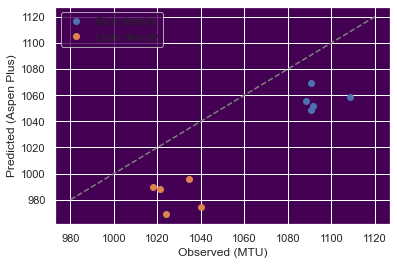

In [24]:
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Data from MTU
D1_MTU = np.array([1088.11499, 1090.425293, 1090.595581, 1091.443726, 1108.435303])
D8_MTU = np.array([1017.941345, 1023.984192, 1020.980042, 1034.57373, 1040.16333])
MTU = np.concatenate((D1_MTU, D8_MTU))

# Data from Aspen Plus
lean_loading = np.array([0.213032066, 0.145038172, 0.171347247, 0.24247849, 0.133190926])
D1_sim = np.array([1055.581956, 1048.781284, 1069.583962, 1051.411844, 1058.672435])
D8_sim = np.array([990.1087732, 968.775124, 987.9521059, 996.0362459, 974.1782947])
sim = np.concatenate((D1_sim, D8_sim))

"""# Regression line
slope, intercept = np.polyfit(MTU, sim, 1)
regression_line = slope * MTU + intercept
r2 = r2_score(sim, regression_line)
print(f"R-squared: {r2}")
x = np.max(MTU)
y = np.min(regression_line)
plt.plot([np.min(MTU), np.max(MTU)], 
         [np.min(regression_line), np.max(regression_line)],
         '--', color='grey')"""

x = 980
y = 1120

plt.plot([x, y], [x, y], '--', color='grey')

# Rest of the plot
plt.rcParams['font.family'] = 'Helvetica'
plt.plot(D1_MTU, D1_sim, 'o', label='Rich density')
plt.plot(D8_MTU, D8_sim, 'o', label='Lean density')
plt.legend()
plt.xlabel('Observed (MTU)')
plt.ylabel('Predicted (Aspen Plus)')
plt.savefig("../figs/Density.pdf", format='pdf', bbox_inches='tight')
plt.show()

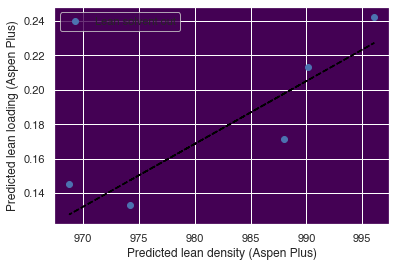

R-squared: 0.8246736427515272


In [25]:
slope, intercept = np.polyfit(D8_sim, lean_loading, 1)
regression_line = slope * D8_sim + intercept
plt.plot(D8_sim, regression_line, '--', color='black')
plt.plot(D8_sim, lean_loading, 'o', label='Lean solvent out')
plt.legend()
plt.xlabel('Predicted lean density (Aspen Plus)')
plt.ylabel('Predicted lean loading (Aspen Plus)')
plt.show()

r2 = r2_score(lean_loading, regression_line)
print(f"R-squared: {r2}")

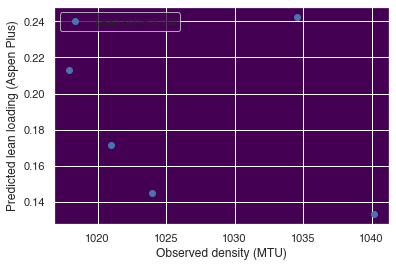

In [26]:
plt.plot(D8_MTU, lean_loading, 'o', label='Lean solvent out')
plt.legend()
plt.xlabel('Observed density (MTU)')
plt.ylabel('Predicted lean loading (Aspen Plus)')
plt.show()